# ATTN: This script uses Google translate to detect job description language. Google translate will limit requests and take a very long time. Only run this script if redoing language detection.

## Read from scrapped data

In [1]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [2]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


Using MPS


0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

#### Read paths

In [3]:
glob_paths = list(set(glob.glob(f'{scraped_data}Coding Material/*Folder/*/Job ID -*- Codebook (Automating Equity).xlsx')))


In [4]:
# 244 xlsx files
len(glob_paths)


244

#### Use paths to open files, fix keywords, and drop unneeded columns

In [5]:
%%time
# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

# Fix list catches all incorrect/faculty keyword search terms
fix_list = []

# Appended data catches all the fixed and cleaned dfs
appended_data = []

for glob_path in glob_paths:

    try:
        df_temp = pd.read_excel(glob_path)
    except ValueError:
        fix_list.append(glob_path)

    if len(df_temp) > 0 and isinstance(df_temp, pd.DataFrame):
        df_temp = df_temp
        df_temp = df_temp.drop(columns=cols, axis='columns', errors='ignore')
        df_temp = df_temp.drop(
        df_temp.columns[
                df_temp.columns.str.contains(
                    'unnamed|index|level', regex=True, case=False, flags=re.I
                )
            ],
            axis='columns',
            errors='ignore',
        )

        appended_data.append(df_temp)

# Concatonate list of dfs into one large df_manual
df_manual = pd.concat(appended_data, axis='index')

# Save df_manual to file
assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_raw.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_raw.csv')


CPU times: user 5.43 s, sys: 142 ms, total: 5.57 s
Wall time: 6.04 s


In [6]:
# If we couldn't fix some keywords, we add them to list fix_list and write to file
if len(fix_list) != 0:
    print('Some keywords to fix!')
    with open(f'{data_dir}fix_list.txt', 'w') as f:
        json.dump(fix_list, f)


In [7]:
# List of dfs, len = 244
len(appended_data)


244

In [8]:
# Concatonate list of dfs into one large df_manual
df_manual = pd.concat(appended_data, axis='index')


In [9]:
# len = 12400
len(df_manual)


12400

In [10]:
# Save df_manual to file
assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_raw.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_raw.csv')


## Drop duplicated and missing data

### START HERE IF SOURCING FROM df_manual_RAW
### PLEASE SET CORRECT DIRECTORY PATHS BELOW

In [11]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [12]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [13]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_raw.pkl')


In [14]:
get_df_info(df_manual, ivs_all=dvs)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12400 entries, 0 to 39
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Job ID           12400 non-null  object 
 1   Sentence         12396 non-null  object 
 2   Warmth           12398 non-null  float64
 3   Competence       12400 non-null  int64  
 4   Task_Mentioned   12398 non-null  float64
 5   Task_Warmth      12398 non-null  float64
 6   Task_Competence  12398 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 775.0+ KB
Warmth:
--------------------
Warmth Counts:
0.00    9572
1.00    2826
Name: Warmth, dtype: int64
--------------------
Warmth Percentages:
0.00   77.20
1.00   22.80
Name: Warmth, dtype: float64
--------------------
Min Warmth value: 0.0
Max Warmth value: 1.0
--------------------
Warmth Mean: 0.23
--------------------
Warmth Standard Deviation: 0.42
Competence:
--------------------
Competence Counts:
0   

In [15]:
# len = 12400
len(df_manual)


12400

In [16]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12400 entries, 0 to 39
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Job ID           12400 non-null  object 
 1   Sentence         12396 non-null  object 
 2   Warmth           12398 non-null  float64
 3   Competence       12400 non-null  int64  
 4   Task_Mentioned   12398 non-null  float64
 5   Task_Warmth      12398 non-null  float64
 6   Task_Competence  12398 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 775.0+ KB


In [17]:
# Clean columns
df_manual.columns = df_manual.columns.to_series().progress_apply(lambda x: str(x).strip())

progress-bar:   0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
# Remove columns 'Task_Mentioned', 'Task_Warmth', 'Task_Competence'
df_manual = df_manual.drop(
    columns=['Task_Mentioned', 'Task_Warmth', 'Task_Competence'],
    axis='columns',
    errors='ignore'
)

In [19]:
df_manual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12400 entries, 0 to 39
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Job ID      12400 non-null  object 
 1   Sentence    12396 non-null  object 
 2   Warmth      12398 non-null  float64
 3   Competence  12400 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 484.4+ KB


In [20]:
# Missing values: Sentence = 4, Warmth = 2, Competence = 0
df_manual.isna().sum()

Job ID        0
Sentence      4
Warmth        2
Competence    0
dtype: int64

In [21]:
# Drop NA
df_manual = df_manual.dropna(axis='index', how='all')
df_manual = df_manual.dropna(axis='columns', how='all')
df_manual = df_manual.dropna(
    subset = ['Sentence', 'Warmth', 'Competence'],
)

In [22]:
# No na values
df_manual.isna().sum()

Job ID        0
Sentence      0
Warmth        0
Competence    0
dtype: int64

In [23]:
get_df_info(df_manual, ivs_all=dvs)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12394 entries, 0 to 39
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Job ID      12394 non-null  object 
 1   Sentence    12394 non-null  object 
 2   Warmth      12394 non-null  float64
 3   Competence  12394 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 484.1+ KB
Warmth:
--------------------
Warmth Counts:
0.00    9568
1.00    2826
Name: Warmth, dtype: int64
--------------------
Warmth Percentages:
0.00   77.20
1.00   22.80
Name: Warmth, dtype: float64
--------------------
Min Warmth value: 0.0
Max Warmth value: 1.0
--------------------
Warmth Mean: 0.23
--------------------
Warmth Standard Deviation: 0.42
Competence:
--------------------
Competence Counts:
0    7330
1    5064
Name: Competence, dtype: int64
--------------------
Competence Percentages:
0   59.10
1   40.90
Name: Competence, dtype: float64
--------------------
Mi

In [24]:
df_manual.columns

Index(['Job ID', 'Sentence', 'Warmth', 'Competence'], dtype='object')

In [25]:
# Convert Warmth and Competence to int
# Warmth 1 = 2826, Competence 1 = 5064
int_cols = [
    'Warmth',
    'Competence',
]

for col in int_cols:
    df_manual[col] = df_manual[col].astype(np.int64, errors='ignore')
    print(f'{col} converted to int.' if all(df_manual[col].progress_apply(lambda x: isinstance(x, int))) else f'{col} NOT converted to int.')
    print(f'{col} value counts:\n{df_manual[col].value_counts()}')


progress-bar:   0%|          | 0/12394 [00:00<?, ?it/s]

Warmth converted to int.
Warmth value counts:
0    9568
1    2826
Name: Warmth, dtype: int64


progress-bar:   0%|          | 0/12394 [00:00<?, ?it/s]

Competence converted to int.
Competence value counts:
0    7330
1    5064
Name: Competence, dtype: int64


In [26]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12394 entries, 0 to 39
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Job ID      12394 non-null  object
 1   Sentence    12394 non-null  object
 2   Warmth      12394 non-null  int64 
 3   Competence  12394 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 484.1+ KB


In [27]:
%%time
# Conver Job ID and Sentence to str
str_cols = [
    'Job ID',
    'Sentence',
]

for col in str_cols:
    df_manual[col] = df_manual[col].astype(str, errors='ignore').progress_apply(lambda x: x.strip().replace('[', '').replace(']', ''))
    print(f'{col} converted to str.' if all(df_manual[col].progress_apply(lambda x: isinstance(x, str))) else f'{col} NOT converted to str.')


progress-bar:   0%|          | 0/12394 [00:00<?, ?it/s]

progress-bar:   0%|          | 0/12394 [00:00<?, ?it/s]

Job ID converted to str.


progress-bar:   0%|          | 0/12394 [00:00<?, ?it/s]

progress-bar:   0%|          | 0/12394 [00:00<?, ?it/s]

Sentence converted to str.
CPU times: user 64.4 ms, sys: 4.64 ms, total: 69.1 ms
Wall time: 109 ms


In [28]:
# len = 12394
len(df_manual)

12394

In [29]:
df_manual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12394 entries, 0 to 39
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Job ID      12394 non-null  object
 1   Sentence    12394 non-null  object
 2   Warmth      12394 non-null  int64 
 3   Competence  12394 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 484.1+ KB


In [30]:
# Rename Sentence to 'Job Description spacy_sentencized'
df_manual = df_manual.rename(
    columns = {
        'Sentence': 'Job Description spacy_sentencized'
    },
    errors='ignore'
)

In [31]:
df_manual.columns


Index(['Job ID', 'Job Description spacy_sentencized', 'Warmth', 'Competence'], dtype='object')

In [32]:
# Drop NA
df_manual = df_manual.dropna(axis='index', how='all')
df_manual = df_manual.dropna(axis='columns', how='all')
df_manual = df_manual.dropna(
    subset = ['Job Description spacy_sentencized', 'Warmth', 'Competence'],
)


In [33]:
# len = 12394
len(df_manual)


12394

In [34]:
# len = 133
len(df_manual.groupby(['Job ID'])['Job ID'].unique())


133

In [35]:
# Drop duplicates on subset of 'Job ID' and 'Sentence'
random.seed(random_state)
np.random.seed(random_state)
df_manual = df_manual.drop_duplicates(subset=['Job ID', 'Job Description spacy_sentencized'], keep='first')


In [36]:
# len = 6400
len(df_manual)


6400

In [37]:
# Remove any rows with missing 'Job ID'
df_manual = df_manual.drop(
    df_manual[
        (df_manual['Job ID'].isin(nan_list)) | 
        (df_manual['Job ID'].isnull()) | 
        (df_manual['Job ID'].isna())
    ].index, 
    axis='index',
)


In [38]:
# len = 6400
len(df_manual)


6400

In [39]:
# Warmth 1 = 1595 (24.90%), Competence 1 = 2836 (44.30%)
get_df_info(df_manual, ivs_all=dvs)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 0 to 239
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Job ID                             6400 non-null   object
 1   Job Description spacy_sentencized  6400 non-null   object
 2   Warmth                             6400 non-null   int64 
 3   Competence                         6400 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 250.0+ KB
Warmth:
--------------------
Warmth Counts:
0    4820
1    1580
Name: Warmth, dtype: int64
--------------------
Warmth Percentages:
0   75.30
1   24.70
Name: Warmth, dtype: float64
--------------------
Min Warmth value: 0
Max Warmth value: 1
--------------------
Warmth Mean: 0.25
--------------------
Warmth Standard Deviation: 0.43
Competence:
--------------------
Competence Counts:
0    3605
1    2795
Name: Competence, dtype: int64
-----------------

In [40]:
# Save df_manual to file
assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_raw_dropped.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_raw_dropped.csv')


## Add English and Dutch language requirement columns

### START HERE IF SOURCING FROM df_manual_RAW_DROPPED
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [41]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [42]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [43]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_raw_dropped.pkl')#


In [44]:
# Warmth 1 = 1595 (24.90%), Competence 1 = 2836 (44.30%)
get_df_info(df_manual, ivs_all=dvs)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 0 to 239
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Job ID                             6400 non-null   object
 1   Job Description spacy_sentencized  6400 non-null   object
 2   Warmth                             6400 non-null   int64 
 3   Competence                         6400 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 250.0+ KB
Warmth:
--------------------
Warmth Counts:
0    4820
1    1580
Name: Warmth, dtype: int64
--------------------
Warmth Percentages:
0   75.30
1   24.70
Name: Warmth, dtype: float64
--------------------
Min Warmth value: 0
Max Warmth value: 1
--------------------
Warmth Mean: 0.25
--------------------
Warmth Standard Deviation: 0.43
Competence:
--------------------
Competence Counts:
0    3605
1    2795
Name: Competence, dtype: int64
-----------------

In [45]:
# 6400
len(df_manual)


6400

In [46]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 0 to 239
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Job ID                             6400 non-null   object
 1   Job Description spacy_sentencized  6400 non-null   object
 2   Warmth                             6400 non-null   int64 
 3   Competence                         6400 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 250.0+ KB


In [47]:
%%time
# Add language requirement column
# Use regex to find language requirement
dutch_requirement_pattern = r'[Ll]anguage: [Dd]utch|[Dd]utch [Pp]referred|[Dd]utch [Re]quired|[Dd]utch [Ll]anguage|[Pp]roficient in [Dd]utch|[Ss]peak [Dd]utch|[Kk]now [Dd]utch'
english_requirement_pattern = r'[Ll]anguage: [Ee]nglish|[Ee]nglish [Pp]referred|[Ee]nglish [Re]quired|[Ee]nglish [Ll]anguage|[Pp]roficient in [Ee]nglish|[Ss]peak [Ee]nglish|[Kk]now [Ee]nglish'

lang_requirements = {
    'Dutch Requirement': dutch_requirement_pattern, 'English Requirement': english_requirement_pattern
}

for lang_req, lang_req_pattern in lang_requirements.items():
    if lang_req in df_manual.columns:
        df_manual = df_manual.drop(columns=[lang_req])
    df_manual[lang_req] = np.where(
        df_manual['Job Description spacy_sentencized'].str.contains(lang_req_pattern),
        'Yes',
        'No',
    )

    df_manual[lang_req] = df_manual[lang_req].astype('category').cat.reorder_categories(['No', 'Yes'], ordered=True)
    df_manual[lang_req] = pd.Categorical(df_manual[lang_req], categories=['No', 'Yes'], ordered=True)

assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_raw_language_requirement.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_raw_english_requirement.csv')


CPU times: user 89.5 ms, sys: 5.16 ms, total: 94.7 ms
Wall time: 164 ms


In [48]:
# Yes = 7
df_manual['Dutch Requirement'].value_counts()


No     6393
Yes       7
Name: Dutch Requirement, dtype: int64

In [49]:
# Yes = 8
df_manual['English Requirement'].value_counts()

No     6392
Yes       8
Name: English Requirement, dtype: int64

In [50]:
assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_raw_language_requirement.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_raw_language_requirement.csv')


## Add data from Sectors dataframe (see CBS directory under scrapped_data directory) and Categorical data


### START HERE IF SOURCING FROM df_manual_RAW_LANGUAGE_REQUIREMENT
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [51]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [52]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [53]:
def get_df_info(df, ivs_all=None):
    if ivs_all is None:
        ivs_all = [
            'Gender',
            'Gender_Num',
            'Gender_Female',
            'Gender_Mixed',
            'Gender_Male',
            'Gender_Female_n',
            'Gender_Male_n',
            'Gender_Female_% per Sector',
            'Gender_Male_% per Sector',
            'Age',
            'Age_Num',
            'Age_Older',
            'Age_Mixed',
            'Age_Younger',
            'Age_Older_n',
            'Age_Younger_n',
            'Age_Older_% per Sector',
            'Age_Younger_% per Sector',
        ]
    # Print Info
    print('\nDF INFO:\n')
    df.info()

    for iv in ivs_all:
        try:
            print('='*20)
            print(f'{iv}:')
            print('-'*20)
            if len(df[iv].value_counts()) < 5:
                print(f'{iv} Counts:\n{df[iv].value_counts()}')
                print('-'*20)
                print(f'{iv} Percentages:\n{df[iv].value_counts(normalize=True).mul(100).round(1).astype(float)}')
                print('-'*20)
            print(f'Min {iv} value: {df[iv].min()}')
            print(f'Max {iv} value: {df[iv].max()}')
            with contextlib.suppress(Exception):
                print('-'*20)
                print(f'{iv} Mean: {df[iv].mean().round(2).astype(float)}')
                print('-'*20)
                print(f'{iv} Standard Deviation: {df[iv].std().round(2).astype(float)}')
        except Exception:
            print(f'{iv} not available.')

    print('\n')


In [54]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_raw_language_requirement.pkl')


In [55]:
# Warmth 1 = 1595 (24.90%), Competence 1 = 2836 (44.30%)
get_df_info(df_manual, ivs_all=dvs)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Job ID                             6400 non-null   object  
 1   Job Description spacy_sentencized  6400 non-null   object  
 2   Warmth                             6400 non-null   int64   
 3   Competence                         6400 non-null   int64   
 4   Dutch Requirement                  6400 non-null   category
 5   English Requirement                6400 non-null   category
dtypes: category(2), int64(2), object(2)
memory usage: 262.5+ KB
Warmth:
--------------------
Warmth Counts:
0    4820
1    1580
Name: Warmth, dtype: int64
--------------------
Warmth Percentages:
0   75.30
1   24.70
Name: Warmth, dtype: float64
--------------------
Min Warmth value: 0
Max Warmth value: 1
--------------------
Warmth Mean: 0.25
------------------

In [56]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Job ID                             6400 non-null   object  
 1   Job Description spacy_sentencized  6400 non-null   object  
 2   Warmth                             6400 non-null   int64   
 3   Competence                         6400 non-null   int64   
 4   Dutch Requirement                  6400 non-null   category
 5   English Requirement                6400 non-null   category
dtypes: category(2), int64(2), object(2)
memory usage: 262.5+ KB


In [57]:
df_manual['Job ID'] = df_manual['Job ID'].progress_apply(lambda x: str(x).lower().strip())


progress-bar:   0%|          | 0/6400 [00:00<?, ?it/s]

In [58]:
df_jobs = pd.read_pickle(f'{df_save_dir}df_jobs_including_sector_genage_data.pkl')


In [59]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17599 entries, 0 to 17598
Data columns (total 57 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Search Keyword                       17599 non-null  object  
 1   Platform                             17599 non-null  category
 2   Job ID                               17599 non-null  object  
 3   Job Title                            17599 non-null  object  
 4   Company Name                         17597 non-null  object  
 5   Location                             17599 non-null  object  
 6   Job Description                      17599 non-null  object  
 7   Rating                               3780 non-null   float64 
 8   Employment Type                      17017 non-null  object  
 9   Company URL                          15959 non-null  object  
 10  Job URL                              17599 non-null  object  
 11  Job Age        

In [60]:
df_jobs['Job ID'] = df_jobs['Job ID'].progress_apply(lambda x: str(x).lower().strip())


progress-bar:   0%|          | 0/17599 [00:00<?, ?it/s]

In [61]:
df_jobs.columns


Index(['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Rating', 'Employment Type', 'Company URL', 'Job URL', 'Job Age', 'Job Age Number', 'Collection Date', 'Data Row', 'Tracking ID', 'Industry', 'Job Date', 'Type of ownership', 'Language', 'Dutch Requirement', 'English Requirement', 'Sector Code', 'Sector', 'Keywords Count', 'Gender_Female_n', 'Gender_Female_% per Sector', 'Gender_Female_% per Social Category', 'Gender_Female_% per Workforce', 'Gender_Male_n', 'Gender_Male_% per Sector', 'Gender_Male_% per Social Category', 'Gender_Male_% per Workforce', 'Gender', 'Age_Older_n', 'Age_Older_% per Sector', 'Age_Older_% per Social Category', 'Age_Older_% per Workforce', 'Age_Younger_n', 'Age_Younger_% per Sector', 'Age_Younger_% per Social Category', 'Age_Younger_% per Workforce', 'Age', 'Sector_n', '% Sector per Workforce', 'Gender_Female', 'Gender_Male', 'Gender_Mixed', 'Age_Mixed', 'Age_Older', 'Age_Younger', 'Gender_Num', 'Age_Num'

In [62]:
df_jobs = df_jobs.drop(
    columns = [
        'Job Description', 'Rating', 'Employment Type',
        'Company URL', 'Job URL', 'Job Age', 'Job Age Number',
        'Collection Date', 'Data Row', 'Tracking ID', 'Job Date',
        'Type of ownership', 'Language', 'Dutch Requirement', 'English Requirement', 
    ],
    errors='ignore'
)

In [63]:
df_jobs.columns


Index(['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Industry', 'Sector Code', 'Sector', 'Keywords Count', 'Gender_Female_n', 'Gender_Female_% per Sector', 'Gender_Female_% per Social Category', 'Gender_Female_% per Workforce', 'Gender_Male_n', 'Gender_Male_% per Sector', 'Gender_Male_% per Social Category', 'Gender_Male_% per Workforce', 'Gender', 'Age_Older_n', 'Age_Older_% per Sector', 'Age_Older_% per Social Category', 'Age_Older_% per Workforce', 'Age_Younger_n', 'Age_Younger_% per Sector', 'Age_Younger_% per Social Category', 'Age_Younger_% per Workforce', 'Age', 'Sector_n', '% Sector per Workforce', 'Gender_Female', 'Gender_Male', 'Gender_Mixed', 'Age_Mixed', 'Age_Older', 'Age_Younger', 'Gender_Num', 'Age_Num', 'Platform_Num', 'Platform_LinkedIn', 'Platform_Indeed', 'Platform_Glassdoor'], dtype='object')

In [64]:
# Add sector and categorical data from df_jobs
df_manual = df_manual.merge(df_jobs, on='Job ID', how='inner')


In [65]:
# len = 5978
len(df_manual)


5978

In [66]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Job ID                               5978 non-null   object  
 1   Job Description spacy_sentencized    5978 non-null   object  
 2   Warmth                               5978 non-null   int64   
 3   Competence                           5978 non-null   int64   
 4   Dutch Requirement                    5978 non-null   category
 5   English Requirement                  5978 non-null   category
 6   Search Keyword                       5978 non-null   object  
 7   Platform                             5978 non-null   category
 8   Job Title                            5978 non-null   object  
 9   Company Name                         5978 non-null   object  
 10  Location                             5978 non-null   object  
 11  Industry         

In [67]:
df_manual.head()

,Job ID,Job Description spacy_sentencized,Warmth,Competence,Dutch Requirement,English Requirement,Search Keyword,Platform,Job Title,Company Name,Location,Industry,Sector Code,Sector,Keywords Count,Gender_Female_n,Gender_Female_% per Sector,Gender_Female_% per Social Category,Gender_Female_% per Workforce,Gender_Male_n,Gender_Male_% per Sector,Gender_Male_% per Social Category,Gender_Male_% per Workforce,Gender,Age_Older_n,Age_Older_% per Sector,Age_Older_% per Social Category,Age_Older_% per Workforce,Age_Younger_n,Age_Younger_% per Sector,Age_Younger_% per Social Category,Age_Younger_% per Workforce,Age,Sector_n,% Sector per Workforce,Gender_Female,Gender_Male,Gender_Mixed,Age_Mixed,Age_Older,Age_Younger,Gender_Num,Age_Num,Platform_Num,Platform_LinkedIn,Platform_Indeed,Platform_Glassdoor
0,p_5d6c53910d6641eb,Zanders is a leading international consultancy...,0,1,No,No,career development specialist,Indeed,Senior Manager Treasury and Treasury Technolog...,Zanders,Bussum,NaN,N,Renting and other business support,8.00,416.00,42.75,3.46,1.65,557.00,57.25,4.20,2.20,Mixed Gender,311.00,31.96,2.93,1.23,660.00,67.83,4.51,2.61,Younger,973.00,3.85,0,0,1,0,0,1,1,2,1,0,1,0
1,p_5d6c53910d6641eb,"From our offices in the Netherlands, Belgium, ...",0,1,No,No,career development specialist,Indeed,Senior Manager Treasury and Treasury Technolog...,Zanders,Bussum,NaN,N,Renting and other business support,8.00,416.00,42.75,3.46,1.65,557.00,57.25,4.20,2.20,Mixed Gender,311.00,31.96,2.93,1.23,660.00,67.83,4.51,2.61,Younger,973.00,3.85,0,0,1,0,0,1,1,2,1,0,1,0
2,p_5d6c53910d6641eb,Zanders Netherlands has established itself as ...,0,1,No,No,career development specialist,Indeed,Senior Manager Treasury and Treasury Technolog...,Zanders,Bussum,NaN,N,Renting and other business support,8.00,416.00,42.75,3.46,1.65,557.00,57.25,4.20,2.20,Mixed Gender,311.00,31.96,2.93,1.23,660.00,67.83,4.51,2.61,Younger,973.00,3.85,0,0,1,0,0,1,1,2,1,0,1,0
3,p_5d6c53910d6641eb,We are therefore hiring an experienced Consult...,0,1,No,No,career development specialist,Indeed,Senior Manager Treasury and Treasury Technolog...,Zanders,Bussum,NaN,N,Renting and other business support,8.00,416.00,42.75,3.46,1.65,557.00,57.25,4.20,2.20,Mixed Gender,311.00,31.96,2.93,1.23,660.00,67.83,4.51,2.61,Younger,973.00,3.85,0,0,1,0,0,1,1,2,1,0,1,0
4,p_5d6c53910d6641eb,We also have positions available in Belgium an...,0,0,No,No,career development specialist,Indeed,Senior Manager Treasury and Treasury Technolog...,Zanders,Bussum,NaN,N,Renting and other business support,8.00,416.00,42.75,3.46,1.65,557.00,57.25,4.20,2.20,Mixed Gender,311.00,31.96,2.93,1.23,660.00,67.83,4.51,2.61,Younger,973.00,3.85,0,0,1,0,0,1,1,2,1,0,1,0


#### Check if there is any missing sector data in the merged dataframe

In [68]:
df_manual['Sector'].isna().sum()

0

In [69]:
if df_manual['Sector'].isna().sum() != 0:
    print('Some search keywords did not match a sector. Fixing')
    print(set(df_manual['Search Keyword'].loc[df_manual['Sector'].isna()].to_list()))
    print(len(df_manual['Search Keyword'].loc[df_manual['Search Keyword'].isin(list(keyword_trans_dict.keys()))]))
    df_manual = fix_keywords(df_manual)
    print(set(df_manual['Search Keyword'].loc[df_manual['Sector'].isna()].to_list()))
    print(len(df_manual['Search Keyword'].loc[df_manual['Search Keyword'].isin(list(keyword_trans_dict.keys()))]))


In [70]:
# Manual Job Ad info, len = 117
get_df_info(df_manual.groupby(['Job ID']).first(), ivs_all=ivs_all)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 3768944208 to pj_a4ac3e531abef752
Data columns (total 46 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Job Description spacy_sentencized    117 non-null    object  
 1   Warmth                               117 non-null    int64   
 2   Competence                           117 non-null    int64   
 3   Dutch Requirement                    117 non-null    category
 4   English Requirement                  117 non-null    category
 5   Search Keyword                       117 non-null    object  
 6   Platform                             117 non-null    category
 7   Job Title                            117 non-null    object  
 8   Company Name                         117 non-null    object  
 9   Location                             117 non-null    object  
 10  Industry                             5 non-null      ob

In [71]:
# Manual Job Sentence info
get_df_info(df_manual, ivs_all=ivs_all)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Job ID                               5978 non-null   object  
 1   Job Description spacy_sentencized    5978 non-null   object  
 2   Warmth                               5978 non-null   int64   
 3   Competence                           5978 non-null   int64   
 4   Dutch Requirement                    5978 non-null   category
 5   English Requirement                  5978 non-null   category
 6   Search Keyword                       5978 non-null   object  
 7   Platform                             5978 non-null   category
 8   Job Title                            5978 non-null   object  
 9   Company Name                         5978 non-null   object  
 10  Location                             5978 non-null   object  
 11  Indust

In [72]:
# Warmth 1 = 1595 (24.90%), Competence 1 = 2836 (44.30%)
get_df_info(df_manual, ivs_all=dvs)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Job ID                               5978 non-null   object  
 1   Job Description spacy_sentencized    5978 non-null   object  
 2   Warmth                               5978 non-null   int64   
 3   Competence                           5978 non-null   int64   
 4   Dutch Requirement                    5978 non-null   category
 5   English Requirement                  5978 non-null   category
 6   Search Keyword                       5978 non-null   object  
 7   Platform                             5978 non-null   category
 8   Job Title                            5978 non-null   object  
 9   Company Name                         5978 non-null   object  
 10  Location                             5978 non-null   object  
 11  Indust

In [73]:
if df_manual['Sector'].isna().sum() == 0:
    assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
    df_manual.to_pickle(f'{df_save_dir}df_manual_including_sector_genage_data.pkl')
    df_manual.to_csv(f'{df_save_dir}df_manual_including_sector_genage_data.csv')
else:
    print(f"MISSING SECTOR DATA: COUNT {df_manual['Sector'].isna().sum()}")

# ATTN: This script should be run AFTER spacy sentence splitting is completed.


## Use spacy to tokenize sentences


### START HERE IF SOURCING FROM df_manual_SENTENCIZED
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [74]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [75]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [76]:
def get_word_num_and_frequency(row, text_col):

    with open(f'{data_dir}punctuations.txt', 'rb') as f:
        custom_punct_chars = pickle.load(f)
    row['Job Description num_words'] = len(str(row[text_col]).split())
    row['Job Description num_unique_words'] = len(set(str(row[text_col]).split()))
    row['Job Description num_chars'] = len(str(row[text_col]))
    row['Job Description num_chars_no_whitespact_and_punt'] = len(
        [
            c.translate({ord(s): None for s in string.whitespace})
            for c in str(row[text_col])
            if c not in custom_punct_chars and c not in string.punctuation
        ]
    )
    row['Job Description num_punctuations'] = len(
        [
            c
            for c in str(row[text_col])
            if c in custom_punct_chars and c in string.punctuation
        ]
    )

    return row


In [77]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_including_sector_genage_data.pkl')


In [78]:
# Warmth 1 = 1595 (24.90%), Competence 1 = 2836 (44.30%)
get_df_info(df_manual, ivs_all=dvs)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Job ID                               5978 non-null   object  
 1   Job Description spacy_sentencized    5978 non-null   object  
 2   Warmth                               5978 non-null   int64   
 3   Competence                           5978 non-null   int64   
 4   Dutch Requirement                    5978 non-null   category
 5   English Requirement                  5978 non-null   category
 6   Search Keyword                       5978 non-null   object  
 7   Platform                             5978 non-null   category
 8   Job Title                            5978 non-null   object  
 9   Company Name                         5978 non-null   object  
 10  Location                             5978 non-null   object  
 11  Indust

In [79]:
df_manual['Job Description spacy_sentencized_lower'] = df_manual['Job Description spacy_sentencized'].progress_apply(
    lambda job_sentence: job_sentence.strip().lower()
)


progress-bar:   0%|          | 0/5978 [00:00<?, ?it/s]

In [80]:
df_manual[['Job Description spacy_sentencized', 'Job Description spacy_sentencized_lower']].head()


,Job Description spacy_sentencized,Job Description spacy_sentencized_lower
0,Zanders is a leading international consultancy...,zanders is a leading international consultancy...
1,"From our offices in the Netherlands, Belgium, ...","from our offices in the netherlands, belgium, ..."
2,Zanders Netherlands has established itself as ...,zanders netherlands has established itself as ...
3,We are therefore hiring an experienced Consult...,we are therefore hiring an experienced consult...
4,We also have positions available in Belgium an...,we also have positions available in belgium an...


In [81]:
%%time
# Spacy tokenize
with open(f'{data_dir}punctuations.txt', 'rb') as f:
    custom_punct_chars = pickle.load(f)

df_manual['Job Description spacy_tokenized'] = df_manual[
    'Job Description spacy_sentencized'
].progress_apply(
    lambda job_sentence: [
        str(token.text.strip().lower())
        for token in nlp.tokenizer(job_sentence)
        if len(token) != 0
        and not token.is_space
        and not token.is_stop
        and not token.is_punct
        and not token.is_bracket
        and not token.like_email
        and token.text not in custom_punct_chars
    ]
)

assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy.csv')


progress-bar:   0%|          | 0/5978 [00:00<?, ?it/s]

CPU times: user 482 ms, sys: 14.7 ms, total: 497 ms
Wall time: 506 ms


In [82]:
df_manual['Job Description spacy_sentencized_cleaned'] = df_manual['Job Description spacy_tokenized'].str.join(' ')


In [83]:
%%time
# Get sentence word frequencies
df_manual = df_manual.progress_apply(
    lambda row: get_word_num_and_frequency(
        row=row, text_col='Job Description spacy_sentencized'
    ), 
    axis='columns',
)


progress-bar:   0%|          | 0/5978 [00:00<?, ?it/s]

CPU times: user 5.51 s, sys: 156 ms, total: 5.67 s
Wall time: 5.88 s


In [84]:
df_manual[
    [
        'Job Description spacy_sentencized',
        'Job Description num_words', 'Job Description num_unique_words',
        'Job Description num_chars', 'Job Description num_chars_no_whitespact_and_punt'
    ]
].head()


,Job Description spacy_sentencized,Job Description num_words,Job Description num_unique_words,Job Description num_chars,Job Description num_chars_no_whitespact_and_punt
0,Zanders is a leading international consultancy...,16,16,122,120
1,"From our offices in the Netherlands, Belgium, ...",22,20,170,165
2,Zanders Netherlands has established itself as ...,12,12,93,92
3,We are therefore hiring an experienced Consult...,33,30,216,215
4,We also have positions available in Belgium an...,10,10,55,54


In [85]:
df_manual.columns


Index(['Job ID', 'Job Description spacy_sentencized', 'Warmth', 'Competence', 'Dutch Requirement', 'English Requirement', 'Search Keyword', 'Platform', 'Job Title', 'Company Name', 'Location', 'Industry', 'Sector Code', 'Sector', 'Keywords Count', 'Gender_Female_n', 'Gender_Female_% per Sector', 'Gender_Female_% per Social Category', 'Gender_Female_% per Workforce', 'Gender_Male_n', 'Gender_Male_% per Sector', 'Gender_Male_% per Social Category', 'Gender_Male_% per Workforce', 'Gender', 'Age_Older_n', 'Age_Older_% per Sector', 'Age_Older_% per Social Category', 'Age_Older_% per Workforce', 'Age_Younger_n', 'Age_Younger_% per Sector', 'Age_Younger_% per Social Category', 'Age_Younger_% per Workforce', 'Age', 'Sector_n', '% Sector per Workforce', 'Gender_Female', 'Gender_Male', 'Gender_Mixed', 'Age_Mixed', 'Age_Older', 'Age_Younger', 'Gender_Num', 'Age_Num', 'Platform_Num', 'Platform_LinkedIn', 'Platform_Indeed', 'Platform_Glassdoor', 'Job Description spacy_sentencized_lower', 'Job Descr

In [86]:
get_df_info(df_manual, ivs_all=ivs_all)


DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 55 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company 

In [87]:
assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy.csv')


## Use NLTK to tokenize sentences


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [88]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [89]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [90]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy.pkl')


In [91]:
# Warmth 1 = 1595 (24.90%), Competence 1 = 2836 (44.30%)
get_df_info(df_manual, ivs_all=dvs)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 55 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company 

In [92]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 55 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company Name       

In [93]:
%%time
# Tokenize with NLTK
stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

df_manual['Job Description nltk_tokenized'] = df_manual['Job Description spacy_sentencized'].progress_apply(
    lambda job_sentence: [
        str(token.strip().lower()) 
        for token in word_tokenize(job_sentence) 
        if len(token) != 0 
        and token != '...' 
        and not token.lower() in set(stopwords.words('english')) 
        and not token.lower() in list(string.punctuation) 
    ]
)

assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk.csv')


progress-bar:   0%|          | 0/5978 [00:00<?, ?it/s]

CPU times: user 5.45 s, sys: 1.78 s, total: 7.23 s
Wall time: 7.99 s


In [94]:
df_manual['Job Description nltk_tokenized'].head()


0    [zanders, leading, international, consultancy,...
1    [offices, netherlands, belgium, united, kingdo...
2    [zanders, netherlands, established, recognized...
3    [therefore, hiring, experienced, consultant, a...
4            [also, positions, available, belgium, uk]
Name: Job Description nltk_tokenized, dtype: object

In [95]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 56 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company Name       

In [96]:
assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk.csv')


## Use gensim to tokenize sentences


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [97]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [98]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [99]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk.pkl')


In [100]:
# Warmth 1 = 1595 (24.90%), Competence 1 = 2836 (44.30%)
get_df_info(df_manual, ivs_all=dvs)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 56 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company 

In [101]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 56 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company Name       

In [102]:
%%time
df_manual['Job Description gensim_tokenized'] = df_manual['Job Description spacy_sentencized'].progress_apply(
    lambda sentence: preprocess_string(re.sub(pattern, ' ', sentence.strip().lower()))
)

assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.csv')


progress-bar:   0%|          | 0/5978 [00:00<?, ?it/s]

CPU times: user 532 ms, sys: 15.1 ms, total: 547 ms
Wall time: 551 ms


In [103]:
df_manual['Job Description gensim_tokenized'].head()


0    [zander, lead, intern, consult, firm, focus, t...
1    [offic, netherland, belgium, unit, kingdom, sw...
2    [zander, netherland, establish, recogn, specia...
3    [hire, experienc, consult, ambit, grow, corpor...
4                              [posit, avail, belgium]
Name: Job Description gensim_tokenized, dtype: object

In [104]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 57 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company Name       

In [105]:
assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.csv')


## Use BERT to tokenize sentences


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY_NLTK_GENSIM
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [1]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [2]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


Using MPS


0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

In [3]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.pkl')


In [4]:
# Warmth 1 = 1595 (24.90%), Competence 1 = 2836 (44.30%)
get_df_info(df_manual, ivs_all=dvs)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 57 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company 

In [5]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 57 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company Name       

In [111]:
%%time
max_length = 512
returned_tensor = 'pt'
cpu_counts = torch.multiprocessing.cpu_count()
device = torch.device('mps') if torch.has_mps and torch.backends.mps.is_built() and torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device_name = str(device.type)
print(f'Using {device_name.upper()}')
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizerFast.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertForSequenceClassification.from_pretrained(bert_model_name).to(device)

df_manual['Job Description bert_tokenized'] = df_manual['Job Description spacy_sentencized'].progress_apply(
    lambda sentence: bert_tokenizer.tokenize(str(sentence))
)

assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.csv')


Using MPS


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

progress-bar:   0%|          | 0/5978 [00:00<?, ?it/s]

CPU times: user 1.36 s, sys: 523 ms, total: 1.88 s
Wall time: 2.74 s


In [112]:
df_manual['Job Description bert_tokenized'].head()


0    [za, ##nder, ##s, is, a, leading, internationa...
1    [from, our, offices, in, the, netherlands, ,, ...
2    [za, ##nder, ##s, netherlands, has, establishe...
3    [we, are, therefore, hiring, an, experienced, ...
4    [we, also, have, positions, available, in, bel...
Name: Job Description bert_tokenized, dtype: object

In [113]:
assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
df_manual.to_pickle(f'{df_save_dir}df_manual_for_trainning.pkl')
df_manual.to_csv(f'{df_save_dir}df_manual_for_trainning.csv')


In [114]:
print(f'Saving df_manual length {len(df_manual)} to txt file.')
with open(f'{data_dir}df_manual_len.txt', 'w') as f:
    f.write(str(len(df_manual)))


Saving df_manual length 5978 to txt file.


## Check data

### START HERE IF SOURCING FROM df_manual_FOR_TRAINNING
### PLEASE SET CORRECT DIRECTORY PATHS BELOW

In [2]:
import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [3]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


Using MPS


0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

In [4]:
with open(f'{data_dir}df_manual_len.txt', 'r') as f:
    df_manual_len = int(f.read())

df_manual = pd.read_pickle(f'{df_save_dir}df_manual_for_trainning.pkl')
assert len(df_manual) == df_manual_len, f'DATAFRAME MISSING DATA! DF SHOULD BE OF LENGTH {df_manual_len} BUT IS OF LENGTH {len(df_manual)}'
print(f'Dataframe loaded with shape: {df_manual.shape}')

Dataframe loaded with shape: (5978, 58)


In [5]:
df_manual.columns.tolist()

['Job ID',
 'Job Description spacy_sentencized',
 'Warmth',
 'Competence',
 'Dutch Requirement',
 'English Requirement',
 'Search Keyword',
 'Platform',
 'Job Title',
 'Company Name',
 'Location',
 'Industry',
 'Sector Code',
 'Sector',
 'Keywords Count',
 'Gender_Female_n',
 'Gender_Female_% per Sector',
 'Gender_Female_% per Social Category',
 'Gender_Female_% per Workforce',
 'Gender_Male_n',
 'Gender_Male_% per Sector',
 'Gender_Male_% per Social Category',
 'Gender_Male_% per Workforce',
 'Gender',
 'Age_Older_n',
 'Age_Older_% per Sector',
 'Age_Older_% per Social Category',
 'Age_Older_% per Workforce',
 'Age_Younger_n',
 'Age_Younger_% per Sector',
 'Age_Younger_% per Social Category',
 'Age_Younger_% per Workforce',
 'Age',
 'Sector_n',
 '% Sector per Workforce',
 'Gender_Female',
 'Gender_Male',
 'Gender_Mixed',
 'Age_Mixed',
 'Age_Older',
 'Age_Younger',
 'Gender_Num',
 'Age_Num',
 'Platform_Num',
 'Platform_LinkedIn',
 'Platform_Indeed',
 'Platform_Glassdoor',
 'Job Descrip

In [6]:
get_df_info(df_manual, ivs_all=dvs)


DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 58 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company 

In [7]:
get_df_info(df_manual, ivs_all=ivs)


DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 58 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company 

In [8]:
get_df_info(df_manual, ivs_all=ivs_dummy)


DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 58 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company 

In [9]:
get_df_info(df_manual, ivs_all=ivs_perc)


DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 58 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Job ID                                            5978 non-null   object 
 1   Job Description spacy_sentencized                 5978 non-null   object 
 2   Warmth                                            5978 non-null   int64  
 3   Competence                                        5978 non-null   int64  
 4   Dutch Requirement                                 5978 non-null   object 
 5   English Requirement                               5978 non-null   object 
 6   Search Keyword                                    5978 non-null   object 
 7   Platform                                          5978 non-null   object 
 8   Job Title                                         5978 non-null   object 
 9   Company 

Running specification curve analysis with:
DEPENDENT VARIABLES = ['Warmth', 'Competence']
INDEPENDENT VARIABLES = ['Gender_Female', 'Gender_Mixed', 'Gender_Male', 'Age_Older', 'Age_Mixed', 'Age_Younger']
CONTROLS = ['% Sector per Workforce', 'Job Description num_words', 'English Requirement', 'Dutch Requirement']
Fit complete


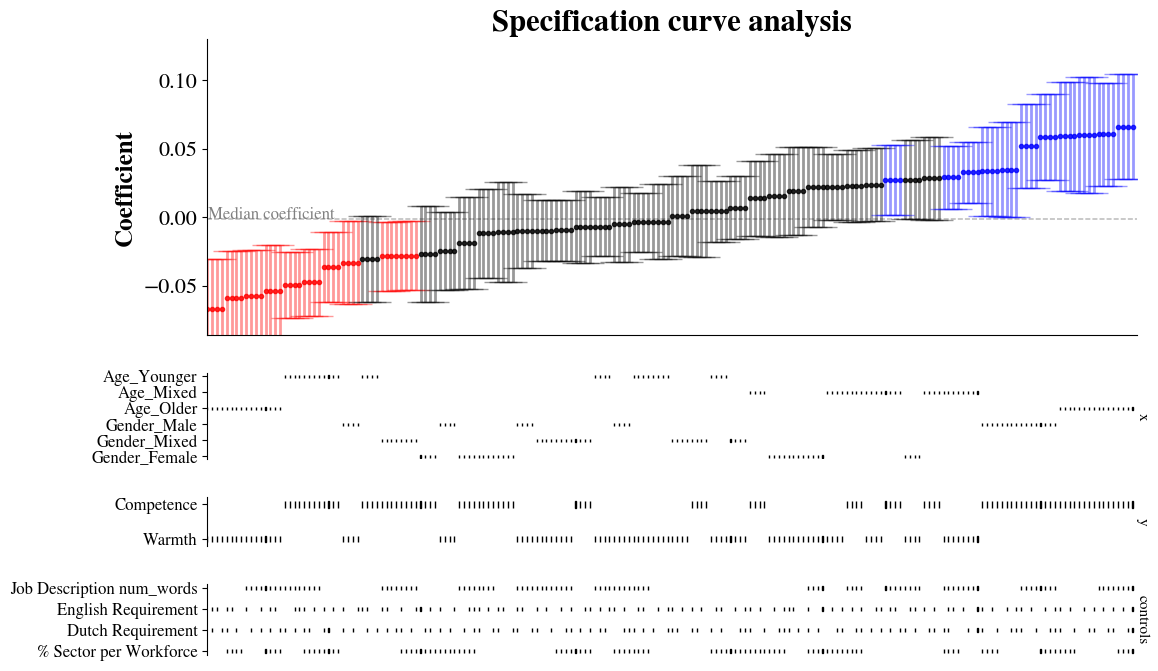

In [10]:
from setup_module import specification_curve_fork as specy # type:ignore # isort:skip # fmt:skip # noqa # nopep8

print(f'Running specification curve analysis with:\nDEPENDENT VARIABLES = {dvs}\nINDEPENDENT VARIABLES = {ivs_dummy}\nCONTROLS = {controls}')
sc = specy.SpecificationCurve(df=df_manual, y_endog=dvs, x_exog=ivs_dummy, controls=controls)
sc.fit(estimator=sm.OLS)
sc.plot(show_plot=True)


Running specification curve analysis with:
DEPENDENT VARIABLES = ['Warmth', 'Competence']
INDEPENDENT VARIABLES = ['Gender_Female_% per Sector', 'Gender_Male_% per Sector', 'Age_Older_% per Sector', 'Age_Younger_% per Sector']
CONTROLS = ['% Sector per Workforce', 'Job Description num_words', 'English Requirement', 'Dutch Requirement']
Optimization terminated successfully.
         Current function value: 0.562937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531318
         Iterations 6
Optimization terminated successfully.
         Cur

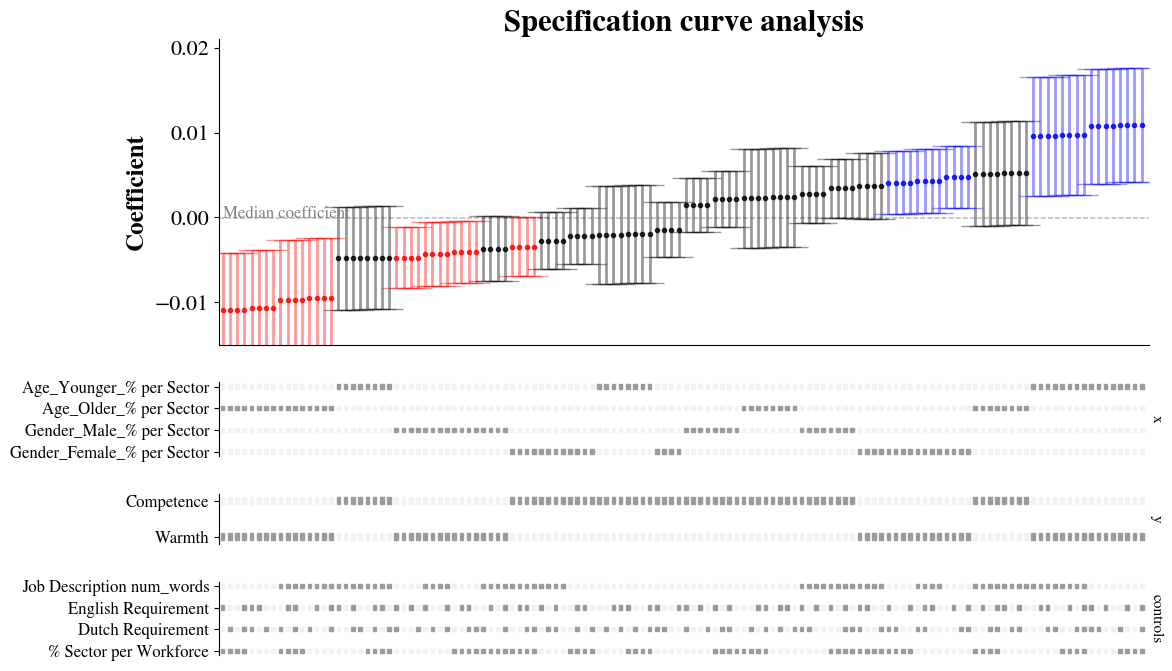

In [11]:
from setup_module import specification_curve_fork as specy # type:ignore # isort:skip # fmt:skip # noqa # nopep8

print(f'Running specification curve analysis with:\nDEPENDENT VARIABLES = {dvs}\nINDEPENDENT VARIABLES = {ivs_perc}\nCONTROLS = {controls}')
sc = specy.SpecificationCurve(df=df_manual, y_endog=dvs, x_exog=ivs_perc, controls=controls)
sc.fit(estimator=sm.Logit)
sc.plot(show_plot=True)


In [117]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.csv')


# ATTN: This script should be run AFTER all tokenization (spacy, nltk, gensim, and BERT) completed.


## Use spacy to create Parts-Of-Speech (POS) tags, lemmas, and stems


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY_NLTK_GENSIM_BERT
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [118]:
# import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# sys.path.append(code_dir)
# # %load_ext autoreload
# # %autoreload 2


In [119]:
# from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [120]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.pkl')


In [121]:
## Warmth 1 = 1595 (24.90%), Competence 1 = 2836 (44.30%)
# get_df_info(df_manual, ivs_all=dvs)


In [122]:
# df_manual.info()


In [123]:
# %%time
# # Load customer characters
# with open(f'{data_dir}punctuations.txt', 'rb') as f:
#     custom_punct_chars = pickle.load(f)

# # POS tagging
# df_manual['Job Description spacy_token_tags'] = df_manual[
#     'Job Description spacy_sentencized'
# ].progress_apply(
#     lambda job_sentence: [
#         (token.text.strip().lower(), token.tag_) for token in nlp(job_sentence)
#     ]
# )

# # Lemmatization
# df_manual['Job Description spacy_lemmas'] = df_manual['Job Description spacy_sentencized'].progress_apply(
#     lambda job_sentence: [
#         token.lemma_.strip().lower()
#         for token in nlp(job_sentence)
#         if len(token) != 0 and not token.is_stop and not token.is_punct and token.text not in custom_punct_chars
#     ]
# )

# # Stemming
# df_manual['Job Description spacy_stems'] = df_manual['Job Description spacy_sentencized'].progress_apply(
#     lambda job_sentence: [
#         stemmer.stem(token.text.strip().lower())
#         for token in nlp(job_sentence)
#         if len(token) != 0 and not token.is_stop and not token.is_punct and token.text not in custom_punct_chars
#     ]
# )

# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.csv')


In [124]:
# df_manual.info()


In [125]:
# df_manual[
#     [
#         'Job Description spacy_token_tags',
#         'Job Description spacy_lemmas',
#         'Job Description spacy_stems'
#     ]
# ].head()


In [126]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.csv')


## Use NLTK to create Parts-Of-Speech (POS) tags, lemmas, and stems


### START HERE IF SOURCING FROM df_manual_TAGS_LEMMAS_STEMS_SPACY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [127]:
# import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# sys.path.append(code_dir)
# # %load_ext autoreload
# # %autoreload 2


In [128]:
# from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [129]:
# def get_wordnet_pos(token):
#     """Map POS tag to first character lemmatize() accepts"""
#     tag = nltk.pos_tag([token])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}

#     return tag_dict.get(tag, wordnet.NOUN)


In [130]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.pkl')


In [131]:
# get_df_info(df_manual, ivs_all=dvs)


In [132]:
# df_manual.info()


In [133]:
# %%time
# # POS tagging
# df_manual['Job Description nltk_token_tags'] = df_manual['Job Description spacy_tokenized'].progress_apply(
#     lambda token: pos_tag(token)
# )

# # Lemmatization
# df_manual['Job Description nltk_lemmas'] = df_manual['Job Description spacy_tokenized'].progress_apply(
#     lambda tokens: [
#         lemmatizer.lemmatize(
#             token, get_wordnet_pos(
#                 unicodedata.normalize('NFKD', str(token.strip().lower())).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#             )
#         )
#         for token in tokens
#     ]
# )

# # Stemming
# df_manual['Job Description nltk_stems'] = df_manual['Job Description spacy_tokenized'].progress_apply(
#     lambda tokens: [
#         stemmer.stem(
#             unicodedata.normalize('NFKD', str(token.strip().lower())).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#         )
#         for token in tokens
#     ]
# )

# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.csv')


In [134]:
# df_manual.info()


In [135]:
# df_manual[['Job Description nltk_token_tags', 'Job Description nltk_lemmas', 'Job Description nltk_stems']].head()


In [136]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.csv')


## Use BERT to create Parts-Of-Speech (POS) tags, lemmas, and stems


### START HERE IF SOURCING FROM df_manual_TAGS_LEMMAS_STEMS_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [137]:
# import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# sys.path.append(code_dir)
# # %load_ext autoreload
# # %autoreload 2


In [138]:
# from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [139]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl')


In [140]:
# get_df_info(df_manual, ivs_all=dvs)


In [141]:
# %%time
# bert_pos_model_name = 'QCRI/bert-base-multilingual-cased-pos-english'
# bert_pos_model = AutoModelForTokenClassification.from_pretrained(bert_pos_model_name).to(device)
# bert_pos_tagger = TokenClassificationPipeline(model=bert_pos_model, tokenizer=bert_tokenizer).to(device)

# df_manual['Job Description bert_token_tags_with_scores'] = df_manual['Job Description spacy_sentencized'].progress_apply(
#     lambda sentence: [
#         (bert_pos_tag['word'], bert_pos_tag['entity'], bert_pos_tag['score'])
#         for i in range(len(sentence.split()))
#         for bert_pos_tag in bert_pos_tagger(sentence)
#     ]
# )

# df_manual['Job Description bert_token_tags'] = df_manual['Job Description bert_token_tags_with_scores'].progress_apply(
#     lambda tag_list: [
#         [(tag_list[i][0], tag_list[i][1])]
#         for tag_tuple in tag_list
#         for i in range(len(tag_list))
#     ]
# )


# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.csv')


In [142]:
# df_manual['Job Description bert_token_tags'].head()

In [143]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.csv')


# ATTN: This script should be run AFTER all POS tagging, lemmatization, and stemming (spacy and nltk) completed. If BERT POS tagging was done, change pkl file loading


## Use spacy to create bi and trigrams


### START HERE IF SOURCING FROM df_manual_TAGS_LEMMAS_STEMS_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [144]:
# import os
# import sys
# import importlib
# from pathlib import Path
# import numpy as np

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# sys.path.append(code_dir)
# # %load_ext autoreload
# # %autoreload 2


In [145]:
# from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [146]:
# def spacy_make_ngrams(sentence, matcher, gram_type):

#     doc = nlp(sentence)
#     matches = matcher(doc)
#     matches_list = []

#     for idx in range(len(matches)):
#         for match_id, start, end in matches:
#             if nlp.vocab.strings[match_id].split('_')[0] == gram_type:
#                 match = doc[matches[idx][1]: matches[idx][2]].text
#                 matches_list.append(match.lower())

#     return list(set(matches_list))


In [147]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.pkl')


In [148]:
# get_df_info(df_manual, ivs_all=dvs)


In [149]:
# %%time
# df_manual['Job Description spacy_1grams_original_list'] = df_manual['Job Description spacy_tokenized']
# df_manual['Job Description spacy_1grams'] = df_manual['Job Description spacy_tokenized'].progress_apply(
#     lambda tokens: [
#         tuple(token.split())
#         for token in tokens
#     ]
# )


In [150]:
# %%time
# # Spacy bi and trigrams
# matcher = Matcher(nlp.vocab)

# bigram_rules = [
#     ['NOUN', 'VERB'],
#     ['VERB', 'NOUN'],
#     ['ADJ', 'NOUN'],
#     ['ADJ', 'PROPN'],
#     # more rules here...
# ]

# trigram_rules = [
#     ['VERB', 'ADJ', 'NOUN'],
#     ['NOUN', 'VERB', 'ADV'],
#     ['NOUN', 'ADP', 'NOUN'],
#     # more rules here...
# ]

# patters_dict = {
#     'bigram_patterns': [[{'POS': i} for i in j] for j in bigram_rules],
#     'trigram_patterns': [[{'POS': i} for i in j] for j in trigram_rules],
# }

# ngram_dict = {
#     'bigram': 2,
#     'trigram': 3,
# }

# for ngram_name, ngram_num in tqdm.tqdm(ngram_dict.items()):

#     matcher.add(f'{ngram_name}_patterns', patters_dict[f'{ngram_name}_patterns'])

#     df_manual[f'Job Description spacy_{str(ngram_num)}grams_original_list'] = df_manual['Job Description spacy_sentencized'].progress_apply(
#         lambda sentence: 
#             [
#                 '_'.join(ngram_.split())
#                 for ngram_ in spacy_make_ngrams(sentence, matcher, ngram_name)
#             ]
#     )

#     df_manual[f'Job Description spacy_{str(ngram_num)}grams'] = df_manual['Job Description spacy_sentencized'].progress_apply(
#         lambda sentence: 
#             [
#                 tuple(ngram_.split())
#                 for ngram_ in spacy_make_ngrams(sentence, matcher, ngram_name)
#             ]
#     )

#     df_manual[f'Job Description spacy_{str(ngram_num)}grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().replace(
#         regex = {
#             re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
#             for ngrams_list in df_manual[f'Job Description spacy_{str(ngram_num)}grams_original_list']
#             for ngram_ in ngrams_list
#             if '_' in ngram_
#         }
#     )

#     if f'{ngram_name}_patterns' in matcher:
#         matcher.remove(f'{ngram_name}_patterns')
#     assert f'{ngram_name}_patterns' not in matcher


In [151]:
# %%time
# # Spacy Allgrams
# df_manual['Job Description spacy_123grams_original_list'] = df_manual['Job Description spacy_tokenized'] + df_manual['Job Description spacy_2grams_original_list'] + df_manual['Job Description spacy_3grams_original_list']
# df_manual['Job Description spacy_123grams'] = df_manual['Job Description spacy_1grams'] + df_manual['Job Description spacy_2grams'] + df_manual['Job Description spacy_3grams']
# df_manual['Job Description spacy_123grams_in_sent'] = (
#     df_manual['Job Description spacy_sentencized']
#     .str.lower()
#     .replace(
#         regex={
#             re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
#             for ngrams_list in df_manual[
#                 'Job Description spacy_123grams_original_list'
#             ]
#             for ngram_ in ngrams_list
#             if '_' in ngram_
#         }
#     )
# )


In [152]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_spacy.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_spacy.csv')


## Use NLTK to create bi and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_SPACY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [153]:
# import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# sys.path.append(code_dir)
# # %load_ext autoreload
# # %autoreload 2


In [154]:
# from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [155]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_spacy.pkl')


In [156]:
# get_df_info(df_manual, ivs_all=dvs)


In [157]:
# %%time
# df_manual['Job Description nltk_1grams_original_list'] = df_manual['Job Description nltk_tokenized']
# df_manual['Job Description nltk_1grams'] = df_manual['Job Description nltk_tokenized'].progress_apply(
#     lambda tokens: [
#         tuple(token.split())
#         for token in tokens
#     ]
# )


In [158]:
# %%time
# # NLTK bi and trigrams
# ngram_dict = {
#     'bigram': 2,
#     'trigram': 3
# }

# for ngram_name, ngram_num in tqdm.tqdm(ngram_dict.items()):

#     df_manual[f'Job Description nltk_{str(ngram_num)}grams_original_list'] = df_manual['Job Description nltk_tokenized'].progress_apply(
#         lambda tokens:
#             list(
#                 '_'.join(ngram_list)
#                 for ngram_list in nltk.ngrams(tokens, ngram_num)
#             )
#     )

#     df_manual[f'Job Description nltk_{str(ngram_num)}grams'] = df_manual['Job Description nltk_tokenized'].progress_apply(
#         lambda tokens: list(nltk.ngrams(tokens, ngram_num))
#     )

#     df_manual[f'Job Description nltk_{str(ngram_num)}grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().replace(
#         regex = {
#             re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
#             for ngrams_list in df_manual[f'Job Description nltk_{str(ngram_num)}grams_original_list']
#             for ngram_ in ngrams_list
#             if '_' in ngram_
#         }
#     )


In [159]:
# %%time
# # NLTK Allgrams
# df_manual['Job Description nltk_123grams_original_list'] = (
#     df_manual['Job Description nltk_tokenized']
#     + df_manual['Job Description nltk_2grams_original_list']
#     + df_manual['Job Description nltk_3grams_original_list']
# )
# df_manual['Job Description nltk_123grams'] = (
#     df_manual['Job Description nltk_1grams']
#     + df_manual['Job Description nltk_2grams']
#     + df_manual['Job Description nltk_3grams']
# )
# df_manual['Job Description nltk_123grams_in_sent'] = (
#     df_manual['Job Description spacy_sentencized']
#     .str.lower()
#     .replace(
#         regex={
#             re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
#             for ngrams_list in df_manual[
#                 'Job Description nltk_123grams_original_list'
#             ]
#             for ngram_ in ngrams_list
#             if '_' in ngram_
#         }
#     )
# )


In [160]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_spacy_nltk.csv')


## Use Gensim to create bi and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [161]:
# import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# sys.path.append(code_dir)
# # %load_ext autoreload
# # %autoreload 2


In [162]:
# from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [163]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk.pkl')


In [164]:
# get_df_info(df_manual, ivs_all=dvs)


In [165]:
# df_manual['Job Description gensim_1grams_original_list'] = df_manual['Job Description gensim_tokenized']
# df_manual['Job Description gensim_1grams'] = df_manual['Job Description gensim_tokenized'].progress_apply(
#     lambda tokens: [
#         tuple(token.split())
#         for token in tokens
#     ]
# )


In [166]:
# %%time
# # Gensim bi and trigrams
# pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'

# # Gensim Bigrams
# bigram = Phraser(Phrases(df_manual['Job Description gensim_tokenized'], connector_words=ENGLISH_CONNECTOR_WORDS, min_count=1, threshold=1))
# df_manual['Job Description gensim_2grams_original_list_all'] = bigram[df_manual['Job Description gensim_tokenized']]
# df_manual['Job Description gensim_2grams_original_list'] = df_manual['Job Description gensim_2grams_original_list_all'].progress_apply(
#     lambda ngrams_list: [
#         ngram_
#         for ngram_ in ngrams_list
#         if len(re.findall('[a-zA-Z]*\_[a-zA-Z]*', ngram_)) != 0
#     ]
# )
# df_manual['Job Description gensim_2grams'] = df_manual['Job Description gensim_2grams_original_list'].progress_apply(
#     lambda ngrams: [
#         tuple(ngram.split('_'))
#         for ngram in ngrams
#         if '_' in ngram
#     ]
# )
# df_manual['Job Description gensim_2grams_in_sent'] = (
#     df_manual['Job Description spacy_sentencized']
#     .str.lower()
#     .progress_apply(
#         lambda sentence: ' '.join(
#             preprocess_string(re.sub(pattern, ' ', sentence.strip().lower()))
#         )
#     )
#     .replace(
#         regex={
#             re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
#             for ngrams_list in df_manual[
#                 'Job Description gensim_2grams_original_list'
#             ]
#             for ngram_ in ngrams_list
#             if '_' in ngram_
#         }
#     )
# )

# # Gensim Trigrams
# trigram = Phraser(Phrases(df_manual['Job Description gensim_2grams_original_list_all'], connector_words=ENGLISH_CONNECTOR_WORDS, min_count=1, threshold=1))
# df_manual['Job Description gensim_3grams_original_list_all'] = trigram[df_manual['Job Description gensim_2grams_original_list_all']]
# df_manual['Job Description gensim_3grams_original_list'] = df_manual['Job Description gensim_3grams_original_list_all'].progress_apply(
#     lambda ngrams_list: [
#         ngram_
#         for ngram_ in ngrams_list
#         if len(re.findall('[a-zA-Z]*\_[a-zA-Z]*\_[a-zA-Z]*', ngram_)) != 0
#     ]
# )
# df_manual['Job Description gensim_3grams'] = df_manual['Job Description gensim_3grams_original_list'].progress_apply(
#     lambda ngrams: [
#         tuple(ngram.split('_'))
#         for ngram in ngrams
#         if '_' in ngram
#     ]
# )
# df_manual['Job Description gensim_3grams_in_sent'] = (
#     df_manual['Job Description spacy_sentencized']
#     .str.lower()
#     .progress_apply(
#         lambda sentence: ' '.join(
#             preprocess_string(re.sub(pattern, ' ', sentence.strip().lower()))
#         )
#     )
#     .replace(
#         regex={
#             re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
#             for ngrams_list in df_manual[
#                 'Job Description gensim_3grams_original_list'
#             ]
#             for ngram_ in ngrams_list
#             if '_' in ngram_
#         }
#     )
# )


In [167]:
# %%time
# # Gensim Allgrams
# pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'

# df_manual['Job Description gensim_123grams_original_list'] = (
#     df_manual['Job Description gensim_tokenized']
#     + df_manual['Job Description gensim_2grams_original_list']
#     + df_manual['Job Description gensim_3grams_original_list']
# )
# df_manual['Job Description gensim_123grams'] = (
#     df_manual['Job Description gensim_1grams']
#     + df_manual['Job Description gensim_2grams']
#     + df_manual['Job Description gensim_3grams']
# )
# df_manual['Job Description gensim_123grams_in_sent'] = (
#     df_manual['Job Description spacy_sentencized']
#     .str.lower()
#     .progress_apply(
#         lambda sentence: ' '.join(
#             preprocess_string(re.sub(pattern, ' ', sentence.strip().lower()))
#         )
#     )
#     .replace(
#         regex={
#             re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
#             for ngrams_list in df_manual[
#                 'Job Description gensim_123grams_original_list'
#             ]
#             for ngram_ in ngrams_list
#             if '_' in ngram_
#         }
#     )
# )


In [168]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk_gensim.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_spacy_nltk_gensim.csv')


## Create word frequencies for uni, bi, and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_SPACY_NLTK_GENSIM
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [169]:
# import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# sys.path.append(code_dir)
# # %load_ext autoreload
# # %autoreload 2


In [170]:
# from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [171]:
# def get_abs_frequency(row, text_col, ngram_num, embedding_library):

#     abs_word_freq = defaultdict(int)
#     for word in row[f'Job Description {embedding_library}_{ngram_num}grams_original_list']:
#         abs_word_freq[word] += 1

#         abs_wtd_df = (
#             pd.DataFrame.from_dict(abs_word_freq, orient='index')
#             .rename(columns={0: 'abs_word_freq'})
#             .sort_values(by=['abs_word_freq'], ascending=False)
#             )
#         abs_wtd_df.insert(1, 'abs_word_perc', value=abs_wtd_df['abs_word_freq'] / abs_wtd_df['abs_word_freq'].sum())
#         abs_wtd_df.insert(2, 'abs_word_perc_cum', abs_wtd_df['abs_word_perc'].cumsum())

#         row[f'Job Description {embedding_library}_{ngram_num}grams_abs_word_freq'] = str(abs_wtd_df['abs_word_freq'].to_dict())
#         row[f'Job Description {embedding_library}_{ngram_num}grams_abs_word_perc'] = str(abs_wtd_df['abs_word_perc'].to_dict())
#         row[f'Job Description {embedding_library}_{ngram_num}grams_abs_word_perc_cum'] = str(abs_wtd_df['abs_word_perc_cum'].to_dict())

#     return row


In [172]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk_gensim.pkl')


In [173]:
# get_df_info(df_manual, ivs_all=dvs)


In [174]:
# %%time
# ngrams_list=[1, 2, 3, 123]
# embedding_libraries_list = ['spacy', 'nltk', 'gensim']

# for embedding_library, ngram_num in tqdm_product(embedding_libraries_list, ngrams_list):
#     df_manual[f'Job Description {embedding_library}_{ngram_num}grams_count'] = df_manual[f'Job Description {embedding_library}_{ngram_num}grams'].apply(lambda x: len(x))
#     df_manual = df_manual.progress_apply(lambda row: get_abs_frequency(row=row, text_col='Job Description spacy_tokenized', ngram_num=ngram_num, embedding_library=embedding_library), axis='columns')


In [175]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_frequency.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_frequency.csv')


## Create BoW dictionary, corpus, and tfidf matrix for uni, bi, and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_FREQUENCY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [176]:
# import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# sys.path.append(code_dir)
# # %load_ext autoreload
# # %autoreload 2


In [177]:
# from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [178]:
# def get_corpus_and_dictionary(row, ngram_num, embedding_library):

#     ngrams_original_list = row[f'Job Description {embedding_library}_{ngram_num}grams_original_list']
#     dictionary = Dictionary([ngrams_original_list])
#     BoW_corpus = [dictionary.doc2bow(ngrams_original_list)]
#     tfidf = TfidfModel(BoW_corpus, smartirs='ntc')
#     tfidf_matrix = [tfidf[doc] for doc in BoW_corpus]

#     row[f'Job Description {embedding_library}_{ngram_num}grams_dictionary'] = dictionary
#     row[f'Job Description {embedding_library}_{ngram_num}grams_BoW_corpus'] = BoW_corpus
#     row[f'Job Description {embedding_library}_{ngram_num}grams_tfidf'] = tfidf
#     row[f'Job Description {embedding_library}_{ngram_num}grams_tfidf_matrix'] = tfidf_matrix

#     return row


In [179]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_frequency.pkl')


In [180]:
# get_df_info(df_manual, ivs_all=dvs)


In [181]:
# %%time
# ngrams_list=[1, 2, 3, 123]
# embedding_libraries_list = ['spacy', 'nltk', 'gensim']
# for embedding_library, ngram_num in tqdm_product(embedding_libraries_list, ngrams_list):
#     df_manual = df_manual.progress_apply(
#         lambda row: get_corpus_and_dictionary(
#             row=row, ngram_num=ngram_num, embedding_library=embedding_library
#         ),
#         axis='columns'
#     )

# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_frequency.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_BoW.csv')


In [182]:
# df_manual.columns


In [183]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_BoW.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_BoW.csv')


# ATTN: This script should be run AFTER all bi and trigrams (spacy, nltk, and gensim) completed.



## Use spacy and nltk for sentiment scoring


### START HERE IF SOURCING FROM df_manual_NGRAMS_BOW
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [184]:
# import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# sys.path.append(code_dir)
# # %load_ext autoreload
# # %autoreload 2


In [185]:
# from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [186]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_BoW.pkl')


In [187]:
# get_df_info(df_manual, ivs_all=dvs)


In [188]:
# %%time
# # Spacy sentiment
# if 'spacytextblob' not in nlp.pipe_names:
#     nlp.add_pipe('spacytextblob')

# df_manual['Job Description spacy_sentiment'] = df_manual['Job Description spacy_sentencized'].progress_apply(
#     lambda sentence: float(nlp(sentence)._.blob.polarity)
#     if isinstance(sentence, str) else np.nan
# )


In [189]:
# %%time
# # NLTK sentiment
# df_manual['Job Description nltk_sentiment'] = df_manual['Job Description spacy_sentencized'].progress_apply(
#     lambda sentence: float(sentim_analyzer.polarity_scores(sentence)['compound'])
#     if isinstance(sentence, str) else np.nan
# )


In [190]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_sentiment_spacy_nltk.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_sentiment_spacy_nltk.csv')


# ATTN: This script should be run AFTER all sentiment scoring (spacy and nltk) completed.


## Word2Vec and FastText embeddings


### START HERE IF SOURCING FROM df_manual_SENTIMENT_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [191]:
# import os # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# import sys # type:ignore # isort:skip # fmt:skip # noqa # nopep8
# from pathlib import Path # type:ignore # isort:skip # fmt:skip # noqa # nopep8

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# sys.path.append(code_dir)
# # %load_ext autoreload
# # %autoreload 2


In [192]:
# from setup_module.imports import *  # type:ignore # isort:skip # fmt:skip # noqa # nopep8


In [193]:
# def build_train_word2vec(df, ngram_number, embedding_library, size = 300, words=None, t = time.time(), cores = multiprocessing.cpu_count()):
#     if words is None:
#         words = [
#             'she',
#             'he',
#             'support',
#             'leader',
#             'management',
#             'team',
#             'business',
#             'customer',
#             'risk',
#             'build',
#             'computer',
#             'programmer',
#         ]
#     sentences = df[f'Job Description {embedding_library}_{ngram_number}grams_original_list'].values

#     w2v_model = Word2Vec(
#         sentences=sentences,
#         vector_size=size,
#         min_count=0,
#         window=2,
#         sample=6e-5,
#         alpha=0.03,
#         min_alpha=0.0007,
#         negative=20,
#         workers=cores - 1,
#         sg = 1,
#     )

#     w2v_model.build_vocab(sentences, progress_per=10000)
#     print(f'Time to train the model for {size}: {round((time.time() - t) / 60, 2)} mins')

#     w2v_model.train(
#         sentences,
#         total_examples=w2v_model.corpus_count,
#         epochs=30,
#         report_delay=1,
#     )

#     print(f'Time to build w2v_vocab for {size}: {round((time.time() - t) / 60, 2)} mins')
#     w2v_vocab = list(w2v_model.wv.index_to_key)

#     print(f'Checking words form list of length {len(words)}')
#     print(f'WORDS LIST: {words}')

# #     for word in words:
# #         print(f'Checking word:\n{word.upper()}:')
# #         try:
# # #             print(f'Word2Vec {size}: {w2v_model.wv[word]}')
# #             print(f'Length of {size} model vobal: {len(w2v_vocab)}')
# #             print(f'{size} - Positive most similar to {word}: {w2v_model.wv.most_similar(positive=word, topn=5)}')
# #             print(f'{size} - Negative most similar to {word}: {w2v_model.wv.most_similar(negative=word, topn=5)}')

# #         except KeyError as e:
# #             print(e)

#     return w2v_vocab, w2v_model

# def word2vec_embeddings(sentences, w2v_vocab, w2v_model, size=300):

#     sentences = [word for word in sentences if word in w2v_vocab]

#     return (
#         np.mean(w2v_model.wv[sentences], axis=0)
#         if sentences
#         else np.zeros(size)
#     )



In [194]:
# def build_train_fasttext(df, ngram_number, embedding_library, size = 300, words=None, t = time.time(), cores = multiprocessing.cpu_count()):
#     if words is None:
#         words = [
#             'she',
#             'he',
#             'support',
#             'leader',
#             'management',
#             'team',
#             'business',
#             'customer',
#             'risk',
#             'build',
#             'computer',
#             'programmer',
#         ]
#     sentences = df[f'Job Description {embedding_library}_{ngram_number}grams_original_list'].values

#     ft_model = FastText(
#         sentences=sentences,
#         vector_size=size,
#         min_count=0,
#         window=2,
#         sample=6e-5,
#         alpha=0.03,
#         min_alpha=0.0007,
#         negative=20,
#         workers=cores - 1,
#         sg = 1,
#     )

#     ft_model.build_vocab(sentences, progress_per=10000)
#     print(f'Time to train the model for {size}: {round((time.time() - t) / 60, 2)} mins')

#     ft_model.train(
#         sentences,
#         total_examples=ft_model.corpus_count,
#         epochs=30,
#         report_delay=1,
#     )

#     print(f'Time to build vocab for {size}: {round((time.time() - t) / 60, 2)} mins')
#     ft_vocab = list(ft_model.wv.index_to_key)

#     print(f'Checking words form list of length {len(words)}')
#     print(f'WORDS LIST: {words}')

# #     for word in words:
# #         print(f'Checking word:\n{word.upper()}:')
# #         try:
# # #             print(f'FastText {size}: {ft_model_300.wv[word]}')
# #             print(f'Length of {size} model vobal: {len(ft_vocab)}')
# #             print(f'{size} - Positive most similar to {word}: {ft_model.wv.most_similar(positive=word, topn=5)}')
# #             print(f'{size} - Negative most similar to {word}: {ft_model.wv.most_similar(negative=word, topn=5)}')

# #         except KeyError as e:
# #             print(e)

#     return ft_vocab, ft_model

# def fasttext_embeddings(sentences, ft_vocab, ft_model, size=300):

#     sentences = [word for word in sentences if word in ft_vocab]

#     return np.mean(ft_model.wv[sentences], axis=0) if sentences else np.zeros(size)


In [195]:
# def get_glove(glove_file = f'{llm_path}/gensim/glove/glove.840B.300d.txt'):
#     embeddings_index = {}
#     with open(glove_file, 'r', encoding='utf8') as glove:

#         for line in glove:
#             values = line.split()
#             word = values[0]

#             with contextlib.suppress(ValueError):
#                 coefs = np.asarray(values[1:], dtype='float32')
#                 embeddings_index[word] = coefs
#     print(f'Found {len(embeddings_index)} word vectors.')

#     return embeddings_index


In [196]:
# def sent2vec(sentences, embeddings_index=None, external_glove=True, extra_preprocessing_enabled=False):

#     if external_glove is False and embeddings_index is None:
#         embeddings_index= get_glove()

#     if extra_preprocessing_enabled is False:
#         words = sentences

#     elif extra_preprocessing_enabled is True:
#         stop_words = set(sw.words('english'))
#         words = str(sentences).lower()
#         words = word_tokenize(words)
#         words = [w for w in words if (w not in stop_words) and (w.isalpha())]

#     M = []

#     try:
#         for w in words:
#             try:
#                 M.append(embeddings_index[w])
#             except Exception:
#                 continue

#         M = np.array(M)
#         v = M.sum(axis='index')
#         return np.zeros(300) if type(v) != np.ndarray else v / np.sqrt((v ** 2).sum())

#     except Exception:
#         return np.zeros(300)


In [197]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_sentiment_spacy_nltk.pkl')


In [198]:
# get_df_info(df_manual, ivs_all=dvs)


In [199]:
# embedding_models_dict = {
#     'w2v': [build_train_word2vec, word2vec_embeddings, Word2Vec],
#     'ft': [build_train_fasttext, fasttext_embeddings, FastText],
# }


In [200]:
# %%time
# # Make embeddings
# ngrams_list=[1, 2, 3, 123]
# embedding_libraries_list = ['spacy', 'nltk', 'gensim']

# for embedding_library, ngram_number in tqdm_product(embedding_libraries_list, ngrams_list):
#     print(f'Building {embedding_library}_{ngram_number}grams model and vocabulary.')

#     for embed_model_name, embed_func_list in tqdm.tqdm(embedding_models_dict.items()):

#         build_train_func, embed_func, model_loader = embed_func_list
#         print(f'Building {embed_model_name} from {embed_func.__name__} function.')

#         vocab, model = build_train_func(
#             df=df_manual,
#             ngram_number=ngram_number,
#             embedding_library=embedding_library,
#         )

#         print(f'Getting {embed_model_name} embeddings.')

#         df_manual[
#             f'Job Description {embedding_library}_{ngram_number}grams_mean_{embed_model_name}_embeddings'
#         ] = df_manual[
#             f'Job Description {embedding_library}_{ngram_number}grams_original_list'
#         ].progress_apply(
#             lambda sentences: embed_func(sentences, vocab, model)
#         )
#         model.save(f'{data_dir}embeddings models/{embedding_library}_{ngram_number}grams_{embed_model_name}_model.model')

#     # Sent2Vec
#     print('Getting sent2vec embeddings.')
#     embeddings_index = get_glove()
#     df_manual[f'Job Description {embedding_library}_{ngram_number}grams_sent2vec_embeddings'] = df_manual[f'Job Description {embedding_library}_{ngram_number}grams'].progress_apply(lambda sentences: sent2vec(sentences, embeddings_index=embeddings_index, external_glove=True, extra_preprocessing_enabled=False))
#     print('Done getting sent2vec embeddings.')


In [201]:
# assert len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame), f'ERORR: LENGTH OF DF = {len(df_manual)}'
# df_manual.to_pickle(f'{df_save_dir}df_manual_for_trainning.pkl')
# df_manual.to_csv(f'{df_save_dir}df_manual_for_trainning.csv')


In [202]:
# print(f'Saving df_manual length {len(df_manual)} to txt file.')
# with open(f'{data_dir}df_manual_len.txt', 'w') as f:
#     f.write(str(len(df_manual)))
